# Analyzing Veros

Veros makes a very nice output that is relatively easy to analyze.  However, it is relatively complex, organized data set, so this document has some pointers to help you get started making calculations using the data it provides.

See also: <https://veros.readthedocs.io/en/latest/tutorial/analysis.html>


## NetCDF and xarray

Veros outputs its files in Network Common Data Format [NetCDF](https://www.unidata.ucar.edu/software/netcdf/).  This is a widely-used portable format that organizes data matrices by co-ordinates.  If we do `ncdump -h example.snapshot.nc` we get entries like:

```
dimensions:
	xt = 200 ;
	xu = 200 ;
	yt = 4 ;
	yu = 4 ;
	zt = 90 ;
	zw = 90 ;
	tensor1 = 2 ;
	tensor2 = 2 ;
	Time = UNLIMITED ; // (30 currently)
variables:
...
double Time(Time) ;
		string Time:long_name = "Time" ;
		string Time:units = "days" ;
		string Time:time_origin = "01-JAN-1900 00:00:00" ;
...
double u(Time, zt, yt, xu) ;
		u:_FillValue = -1.e+18 ;
		string u:long_name = "Zonal velocity" ;
		string u:units = "m/s" ;
...
double temp(Time, zt, yt, xt) ;
		temp:_FillValue = -1.e+18 ;
		string temp:long_name = "Temperature" ;
		string temp:units = "deg C" ;
...

```

So, there are x,y,z and Time dimensions, and each of the variables is assigned to one or more of those dimensions. For instance `temp` is a 4-dimensional variable with the three spatial dimensions and the one time dimension, and represents the evolution of temperature in the model over time.  

NetCDF files can be quite large and sometimes cannot be read into memory on one machine.  Fortunately the libraries that are written around them are very clever, and allow only parts of the files to be read or written at a time.  So in the above, it is entirely possible with the right software to just read into memory one time step of one of the variables, which in this case is 90x4x200 large. 
[Xarray](https://docs.xarray.dev/en/stable/) is a very powerful way to work with NetCDF-like data sets and allows very efficient operations on NetCDF files.  It is heavily based on numpy, which many students have already used, and also borrows many concepts from pandas.  To read a data set into python we can use xarray:

In [242]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

# This makes it so we don't automatically see data variables.  However you can click on the 
# icon next to the variable to see the values if desired.  You don't need to do this; its just
# being done to make the notebook compact:
xr.set_options(display_expand_data=False, display_expand_coords=False)

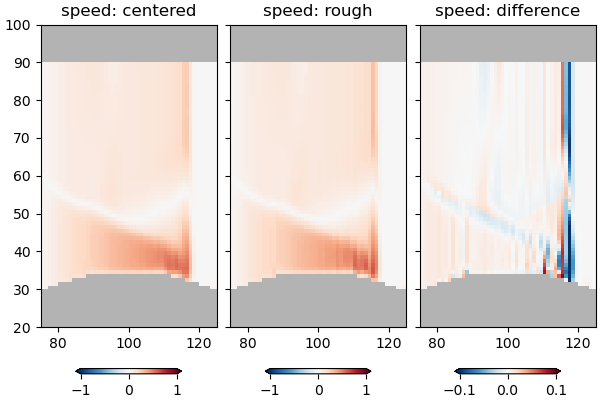

In [269]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(Time=2)
    
    ds['vcenter'] = ds.v.rolling(yu=2).mean().swap_dims({'yu':'yt'})
    ds['ucenter'] = ds.u.rolling(xu=2).mean().swap_dims({'xu':'xt'})
    ds['abs_speed'] = (ds.ucenter**2 + ds.vcenter**2)**(0.5)
    abs_speed = (ds.u.values**2 + ds.v.values**2)**(0.5)
    ds['rough_speed'] = (('zt', 'yt', 'xt'), abs_speed)

    ds = ds.isel(yt=1, yu=1)
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True,
                            layout='constrained', subplot_kw={'facecolor': '0.7'},
                           figsize=(6, 4))
    pc = axs[0].pcolormesh(ds.abs_speed, clim=[-1, 1], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[0].set_title('speed: centered')
    
    pc = axs[1].pcolormesh(ds.rough_speed, clim=[-1, 1], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[1].set_title('speed: rough')
    pc = axs[2].pcolormesh(ds.rough_speed - ds.abs_speed, clim=[-1/10, 1/10], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[2].set_title('speed: difference')
    axs[2].set_xlim([75, 125])
    axs[2].set_ylim([20, 100])

In [243]:
with xr.open_dataset('example.snapshot.nc') as ds:
    display(ds)

<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, yt: 4, yu: 4, zt: 90, zw: 90,
                        tensor1: 2, tensor2: 2, Time: 6)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                (yt) float64 ...
    dyu                (yu) float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (Time, zt, yt, xt) float64 ...
    kappaH             (Time, zw, yt, xt) float64 ...
    surface_taux       (Time, yt, xu) float64 ...
    surface_tauy       (Time, yu, xt) float64 ...
    forc_rho_surface   (Time, yt, xt) float64 ...
    psi                (Time, yt, xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

Note that in the above, you can click on the triangles to expand or collapse the `Data variables` or the `Coordinates`. 

As you can see the xarray data set has the same structure as the NetCDF file.  In addition it has the concept of `Coordinates`, which are special variables that correspond to the dimensions.  

Each `Dataset` is composed of one or more `DataArrays` which often share coordinates and dimensions with other `DataArrays` in the `Dataset`. 
So in the above `temp` and `salt` are `DataArray`s representing temperature and salinity in the model, and they share the dimensions `Time, zt, xt`.  

In [244]:
display(ds.temp)
display(ds.salt)

<xarray.DataArray 'temp' (Time: 6, zt: 90, yt: 4, xt: 200)>
[432000 values with dtype=float64]
Coordinates: (4)
Attributes:
    long_name:  Temperature
    units:      deg C

<xarray.DataArray 'salt' (Time: 6, zt: 90, yt: 4, xt: 200)>
[432000 values with dtype=float64]
Coordinates: (4)
Attributes:
    long_name:  Salinity
    units:      g/kg

## Veros coordinates

The coordinates above are all doubled except for `Time`, e.g. there is a pair `xt` and `xu`.  This is because Veros is solved on what is called an Arakawa C-Grid, with the velocities specified on the edges of grid cells that have temperature, salinity, pressure, and other tracers at their centre.  See [Veros Model Domain](https://veros.readthedocs.io/en/latest/introduction/introduction.html#the-model-domain) for more details, but the diagram looks like:

![](https://veros.readthedocs.io/en/latest/_images/c-grid.svg)

So, in the above, the variable `u` has dimensions `(Time, zt, yt, xu)`, `v` has dimensions `(time, zt, yu, xt)` and `temp` has dimensions `(Time, zt, yt, xt)`.  The vertical velocity `w` has dimensions `(Time, zw, yt, xt)`.  

## Selecting data

The data set above is probably not too big to fit in memory, but it still may be preferable to select subsets of the data.  Xarray makes this realtively straight forward.  

### Selecting data by dimension index: `isel`

The method `isel` means "index selection".  Suppose I want the 3rd timestep, and I only want a slice of data at the first value of y, then I can use `isel` and reduce _all_ the variables at the same time:

In [245]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(yt=0, yu=0, Time=2)
    display(ds)

<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, zt: 90, zw: 90, tensor1: 2, tensor2: 2)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                float64 ...
    dyu                float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (zt, xt) float64 ...
    kappaH             (zw, xt) float64 ...
    surface_taux       (xu) float64 ...
    surface_tauy       (xt) float64 ...
    forc_rho_surface   (xt) float64 ...
    psi                (xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

Compare to the full Dataset above, and note that `yt`, `yu`, and `time` no longer have "Dimension", which means the are just single valued in this new Dataset.

You can access variables in the Dataset using either a `ds.temp` or `ds['temp']` syntax.  Note below that the `temp` (temperature) variable just has two dimensions associated with it.  

In [246]:
display(ds.temp)

<xarray.DataArray 'temp' (zt: 90, xt: 200)>
[18000 values with dtype=float64]
Coordinates: (5)
Attributes:
    long_name:  Temperature
    units:      deg C

You can also specify ranges of variables, so for instance the 3rd to 6th time values.  Note that the new variables retain the `Time` dimension.  

In [247]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(yt=0, yu=0, Time=range(2,6))
    display(ds)
    display(ds.temp)

<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, zt: 90, zw: 90, tensor1: 2,
                        tensor2: 2, Time: 4)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                float64 ...
    dyu                float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (Time, zt, xt) float64 ...
    kappaH             (Time, zw, xt) float64 ...
    surface_taux       (Time, xu) float64 ...
    surface_tauy       (Time, xt) float64 ...
    forc_rho_surface   (Time, xt) float64 ...
    psi                (Time, xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

<xarray.DataArray 'temp' (Time: 4, zt: 90, xt: 200)>
[72000 values with dtype=float64]
Coordinates: (5)
Attributes:
    long_name:  Temperature
    units:      deg C

### Selecting data by coordinate value: `sel`

If you want to work with values of coordinates, rather than indices, that is possible using the `sel` method.  Note here we use `slice` notation to specify a range in time.  `np.timedelta64(6, 'h')` means 6 hours from the start of the simulation.  

In [248]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # get data between 6 and 11 hourse since start of simulation:
    ds = ds.isel(yt=0, yu=0).sel(Time=slice(np.timedelta64(6, 'h'), np.timedelta64(11, 'h')))
    display(ds)
    print(ds.Time.values)


<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, zt: 90, zw: 90, tensor1: 2,
                        tensor2: 2, Time: 3)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                float64 ...
    dyu                float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (Time, zt, xt) float64 ...
    kappaH             (Time, zw, xt) float64 ...
    surface_taux       (Time, xu) float64 ...
    surface_tauy       (Time, xt) float64 ...
    forc_rho_surface   (Time, xt) float64 ...
    psi                (Time, xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

[21600000000000 28799999971200 36000000028800]


If we would prefer to just get one time value then that is easy if we choose a co-ordinate value:

In [249]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(yt=0, yu=0).sel(Time=np.timedelta64(6, 'h'))
    display(ds)


<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, zt: 90, zw: 90, tensor1: 2, tensor2: 2)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                float64 ...
    dyu                float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (zt, xt) float64 ...
    kappaH             (zw, xt) float64 ...
    surface_taux       (xu) float64 ...
    surface_tauy       (xt) float64 ...
    forc_rho_surface   (xt) float64 ...
    psi                (xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

But if we do not choose a value that is exactly in the coordinate we can get an error:

In [250]:
# ignore this "xmode" magic; it just makes the Error message _much_ shorter below
%xmode Minimal

with xr.open_dataset('example.snapshot.nc') as ds:
    # time is 370 minutes, or just a bit off from 6 h where we have data:
    ds = ds.isel(yt=0, yu=0).sel(Time=np.timedelta64(6*60+10, 'm'))
    

Exception reporting mode: Minimal


KeyError: "not all values found in index 'Time'. Try setting the `method` keyword argument (example: method='nearest')."

In this case we can still proceed using the error message above as guidance:

In [251]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # time is 370 minutes, or just a bit off from 6 h where we have data:
    ds = ds.isel(yt=0, yu=0).sel(Time=np.timedelta64(6*60+10, 'm'), method='nearest')
    display(ds)

<xarray.Dataset>
Dimensions:            (xt: 200, xu: 200, zt: 90, zw: 90, tensor1: 2, tensor2: 2)
Coordinates: (9)
Data variables: (12/33)
    dxt                (xt) float64 ...
    dxu                (xu) float64 ...
    dyt                float64 ...
    dyu                float64 ...
    dzt                (zt) float64 ...
    dzw                (zw) float64 ...
    ...                 ...
    kappaM             (zt, xt) float64 ...
    kappaH             (zw, xt) float64 ...
    surface_taux       (xu) float64 ...
    surface_tauy       (xt) float64 ...
    forc_rho_surface   (xt) float64 ...
    psi                (xt) float64 ...
Attributes:
    date_created:      2023-08-11T20:45:56.009991
    veros_version:     1.4.2+365.gfd1e6a5
    setup_identifier:  hydraulic

Notice that the Time that gets chosen in `06:00:00`.  Of course you can do the same selection mechanisms with other coordinates.  

## Dealing with staggered grids

The staggering of the variable locations (mentioned above), sometime doesn't matter, but it is good to keep track of.  It is also the source of a potential pitfall when using xarray.  If the dimensions of two variables do not match, unexpected things can happen. For instance, its not terribly useful, but imagine we wanted to get the speed from the `u` and `v` values.  We might naively do this, forgetting that the dimensions are different:

In [252]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(Time=2)
    abs_speed = (ds.u**2 + ds.v**2)**(0.5)
    display(abs_speed)

<xarray.DataArray (zt: 90, yt: 4, xu: 200, yu: 4, xt: 200)>
3.104e-06 3.104e-06 3.104e-06 3.104e-06 3.104e-06 ... nan nan nan nan nan
Coordinates: (6)

Note that this new DataArray has three dimensions, whereas we almost certaily wanted it to just have two.  Note that the new data array is also much larger than expected!  

### Averaging to common coordinates

The right way to add together the data on different coordinates is to average both onto the center of the cells, which is possible directly in xarray:

In [253]:
ds['ucenter'] = ds.u.rolling(xu=2, center=True).mean().swap_dims({'xu':'xt'})
display(ds.ucenter)

<xarray.DataArray 'ucenter' (zt: 90, yt: 4, xt: 200)>
nan 4.653e-06 7.759e-06 1.09e-05 1.41e-05 ... 1.232e-05 8.825e-06 5.318e-06 nan
Coordinates: (4)
Attributes:
    long_name:  Zonal velocity
    units:      m/s

Note there were three steps to to this process 1) create a `rolling` object in the `xu` dimension, and then 2) take the mean.  3) The dimensions of the new object are still `xu`.  We can assign the dimensions as `xt` instead using `swap_dims`.

Now when we calculate the speed, the dimesnions match:

In [254]:
ds['vcenter'] = ds.v.rolling(yu=2).mean().swap_dims({'yu':'yt'})
abs_speed = (ds.ucenter**2 + ds.vcenter**2)**(0.5)
display(abs_speed)

<xarray.DataArray (zt: 90, yt: 4, xt: 200)>
nan nan nan nan nan nan nan nan nan nan ... nan nan nan nan nan nan nan nan nan
Coordinates: (4)

### Ignoring coordinates:

If we are not concerned with accuracy, we can also cheat and just use the values of the arrays and create a new variable:

In [255]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(Time=2)
    abs_speed = (ds.u.values**2 + ds.v.values**2)**(0.5)
    display(abs_speed)

array([[[3.10383528e-06, 6.20197602e-06, 9.31639977e-06, ...,
         5.29133439e-06, 2.62353498e-06,            nan],
        [3.10383528e-06, 6.20197602e-06, 9.31639977e-06, ...,
         5.29133439e-06, 2.62353498e-06,            nan],
        [3.10383528e-06, 6.20197602e-06, 9.31639977e-06, ...,
         5.29133439e-06, 2.62353498e-06,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[3.10649400e-06, 6.21225782e-06, 9.33879833e-06, ...,
         5.30169787e-06, 2.62621381e-06,            nan],
        [3.10649399e-06, 6.21225782e-06, 9.33879833e-06, ...,
         5.30169788e-06, 2.62621381e-06,            nan],
        [3.10649400e-06, 6.21225782e-06, 9.33879833e-06, ...,
         5.30169787e-06, 2.62621381e-06,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[3.10757739e-06, 6.21627092e

Note that this is just a numpy array - if we want to make part of the Dataset we can just assign coordinates

In [256]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(Time=2)    
    ds['rough_speed'] = (('zt', 'yt', 'xt'), abs_speed)
    display(ds.rough_speed)

<xarray.DataArray 'rough_speed' (zt: 90, yt: 4, xt: 200)>
3.104e-06 6.202e-06 9.316e-06 1.248e-05 1.573e-05 ... nan nan nan nan nan
Coordinates: (4)

For fun, lets compare the two estimates along one slice in y:

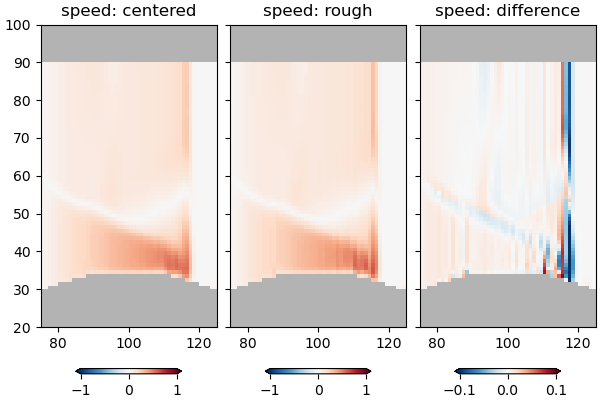

In [257]:
with xr.open_dataset('example.snapshot.nc') as ds:
    ds = ds.isel(Time=2)
    
    ds['vcenter'] = ds.v.rolling(yu=2).mean().swap_dims({'yu':'yt'})
    ds['ucenter'] = ds.u.rolling(xu=2).mean().swap_dims({'xu':'xt'})
    ds['abs_speed'] = (ds.ucenter**2 + ds.vcenter**2)**(0.5)
    
    ds['rough_speed'] = (('zt', 'yt', 'xt'), abs_speed)
    ds = ds.isel(yt=1, yu=1)
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True,
                            layout='constrained', subplot_kw={'facecolor': '0.7'},
                           figsize=(6, 4))
    pc = axs[0].pcolormesh(ds.abs_speed, clim=[-1, 1], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[0].set_title('speed: centered')
    
    pc = axs[1].pcolormesh(ds.rough_speed, clim=[-1, 1], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[1].set_title('speed: rough')
    pc = axs[2].pcolormesh(ds.rough_speed - ds.abs_speed, clim=[-1/10, 1/10], cmap='RdBu_r')
    fig.colorbar(pc, extend='both', shrink=0.6, orientation='horizontal')
    axs[2].set_title('speed: difference')
    axs[2].set_xlim([75, 125])
    axs[2].set_ylim([20, 100])


So there is some difference, but its maybe only noticable where there are sharp, poorly resolved parts of the velocity field.

## Plotting and secondary calculations with data

We saw an example of plotting data above.  Ideally you have been exposed to data presentation techniques in other classes.  

If you are using xarray you will likely use [Matplotlib](https://matplotlib.org) for data visualization.  As in the example above, this usually consists of taking a slice of data and plotting with `contour` or `pcolormesh`.  As an example that gets used a lot, lets use pcolormesh for velocity, and contour the temperature field over top:

### Raw matplotlib:

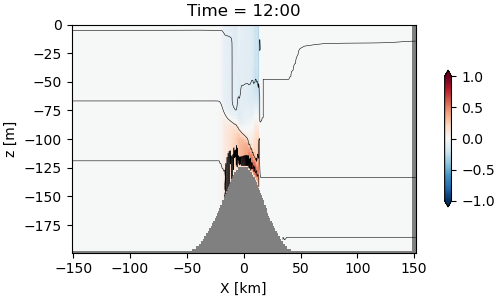

In [258]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    
    fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))
    #make the background grey
    ax.set_facecolor('0.5')

    pc = ax.pcolormesh(ds.xt, ds.zw, ds.u[1:, 1:], clim=[-1, 1], cmap='RdBu_r')
    ax.contour(ds.xt, ds.zt, ds.temp, levels=np.arange(10, 20, 2), colors='k', linewidths=0.4)
    
    # label:
    ax.set_xlabel('X [km]')
    ax.set_ylabel('z [m]')

    # make a colorbar
    fig.colorbar(pc, shrink=0.6, extend='both')

    # convert time to hours:
    hours = int(ds.Time.values/ np.timedelta64(1, 'h'))
    ax.set_title(f'Time = {hours}:00')

Sometimes it is nice to do lots of time slices, which is relatively straight forward:

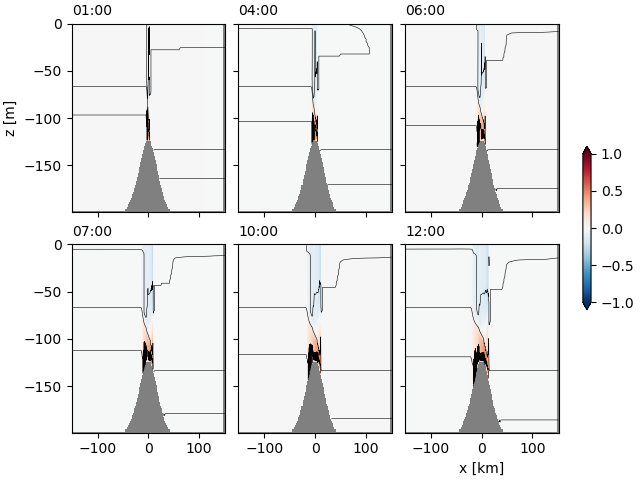

In [259]:
with xr.open_dataset('example.snapshot.nc') as ds0:
    # choose a time slice, and one value of yu and yt:
    ds0 = ds0.isel(yu=1, yt=1)
    fig, axs = plt.subplots(2, 3, layout='constrained', 
                            subplot_kw={'facecolor':'0.7'},
                           sharex=True, sharey=True)
    for nn, time in enumerate(range(0, 6)):
        ds = ds0.isel(Time=time)
        ax = axs.flat[nn]
        #make the background grey
        ax.set_facecolor('0.5')

        pc = ax.pcolormesh(ds.xt, ds.zw, ds.u[1:, 1:], clim=[-1, 1], cmap='RdBu_r')
        ax.contour(ds.xt, ds.zt, ds.temp, levels=np.arange(10, 20, 2), colors='k', linewidths=0.4)
        hours = int(ds.Time.values/ np.timedelta64(1, 'h'))
        ax.set_title(f'{hours:02d}:00', fontsize='medium', loc='left')
    # label the axes:
    
    axs[0, 0].set_ylabel('z [m]')
    axs[1, 2].set_xlabel('x [km]')
    # make a colorbar
    fig.colorbar(pc, ax=axs, shrink=0.4, extend='both')


### Xarray plotting helpers

Xarray have some short cuts for plotting data.  These can work well, particularly for a quick look, but lack some of the flexibility of the Matplotlib plotting:

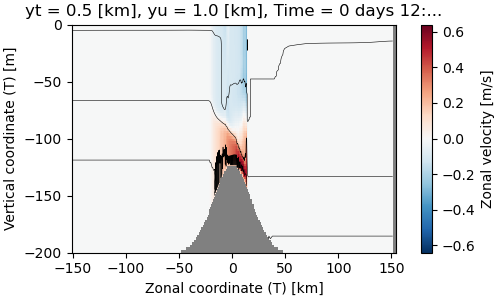

In [260]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    
    fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))
    #make the background grey
    ax.set_facecolor('0.5')
    
    ds.u.plot.pcolormesh(clim=[-1, 1])
    ds.temp.plot.contour(levels=np.arange(10, 20, 2), colors='k', linewidths=0.4)
    


This is perfectly acceptable; note how xarray makes the labels for us, which is quite convenient.  You probably would not want to publish a plot like this, but could be fine.  

Note a trick is that if you don't like 'Zonal coordinate (T) [km]', you can go ahead and change the attributes - its a bit silly to do so here, but if you develop a processing script for your xarray data you could easily do this every time you load a data set.

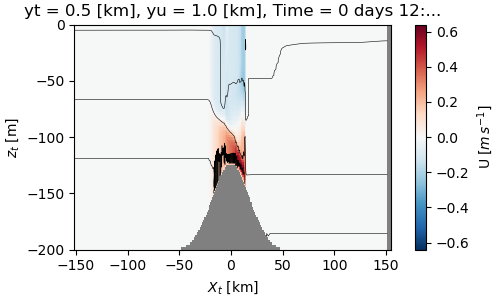

In [261]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    ds.xu.attrs['long_name'] = '$X_u$'
    ds.xt.attrs['long_name'] = '$X_t$'
    ds.zt.attrs['long_name'] = '$z_t$'
    ds.zw.attrs['long_name'] = '$z_w$'
    ds.u.attrs['long_name'] = 'U'
    ds.u.attrs['units'] = '$m\,s^{-1}$'
    
    fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))
    #make the background grey
    ax.set_facecolor('0.5')
    
    ds.u.plot.pcolormesh(clim=[-1, 1])
    ds.temp.plot.contour(levels=np.arange(10, 20, 2), colors='k', linewidths=0.4)
    

### Integration

Often we will want to integrate something.  Suppose for the above we want to get an estimate of the heat content:

$$Q = \int_{-H}^{0} \rho c_p T \ \mathrm{d}z$$

where $\rho = 1000 \ \mathrm{kg\,m^{-3}}$ is the density of water, $c_p = 4000\ \mathrm{J/(kg K)}$ is the heat capacity of seawater, and $Q$ has units of $J\,m^{-2}$ and is a density of heat content per area in the horizontal direction.

In [262]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    rho = 1000  # kg/m^3
    cp = 4000  # J / (kg K)
    heat = (ds.temp+273).integrate(coord='zt') * cp * rho

    display(heat)


<xarray.DataArray 'temp' (xt: 200)>
2.249e+11 2.249e+11 2.249e+11 2.249e+11 ... 2.26e+11 2.26e+11 2.26e+11 2.26e+11
Coordinates: (4)

So, we see above that this probably worked, but that there is an error in that there are many `nan` values that occured because we integrated into the topography. Rather than trying to do something fancy, a reasonable approach is just to replace the `nan` in the original `temp` variable by zeros:

In [263]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    rho = 1000  # kg/m^3
    cp = 4000  # J / (kg K)
    temp=(ds.temp+273).fillna(0)
    
    heat = temp.integrate(coord='zt') * cp * rho

    display(heat)

<xarray.DataArray 'temp' (xt: 200)>
2.249e+11 2.249e+11 2.249e+11 2.249e+11 ... 2.26e+11 2.26e+11 2.26e+11 2.26e+11
Coordinates: (4)

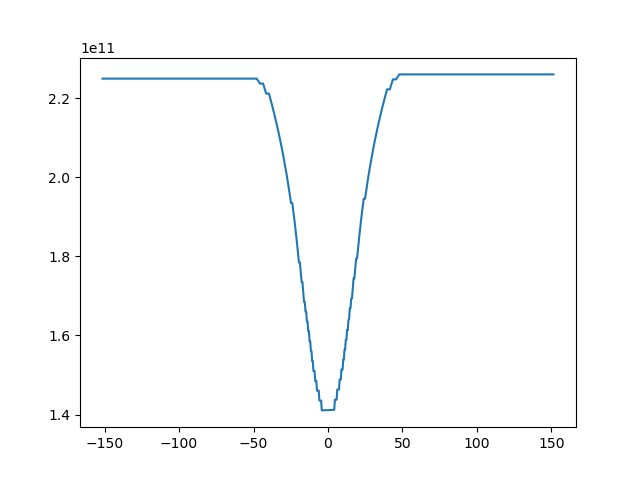

In [264]:
fig, ax = plt.subplots()
ax.plot(heat.xt, heat)

### Differentiation

Xarray also has a differentiation method.  The value $-\frac{1}{\rho}dP/dx$ is used quite often.  Note that in Veros, the density is broken into an interior component, `p_hydro` and a component due to the surface tilt `psi`.  The dynamical quantity is really `P/\rho` so Veros stores the variables in these units ($\mathrm{m^2\,s^{-2}}$).  Note that $-\frac{1}{\rho}dP/dx$ has units of acceleration and is the pressure gradient force.

<xarray.DataArray 'p_hydro' (zt: 90, xt: 200)>
-3.814e-08 -5.729e-08 -8.816e-08 -1.093e-07 ... 2.679e-08 1.751e-08 1.189e-08
Coordinates: (5)

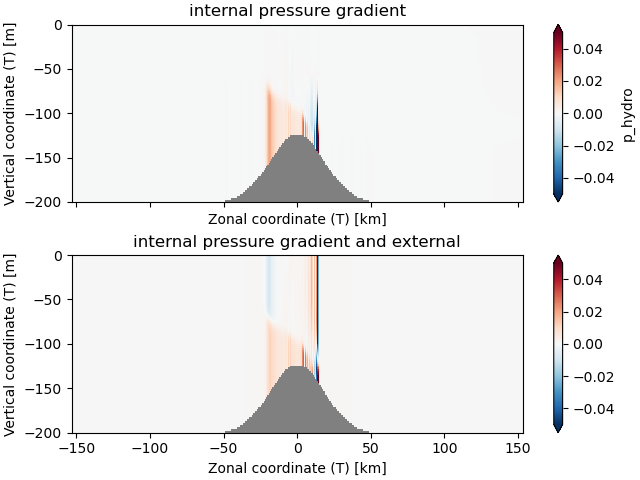

In [265]:
with xr.open_dataset('example.snapshot.nc') as ds:
    # choose a time slice, and one value of yu and yt:
    ds = ds.isel(Time=5, yu=1, yt=1)
    
    dpdx = -ds.p_hydro.differentiate(coord='xt')
    dpsidx = -ds.psi.differentiate(coord='xt')
    display(dpdx)
    fig, axs = plt.subplots(2, 1, layout='constrained', sharex=True, sharey=True)
    ax = axs[0]
    ax.set_facecolor('0.5')
    dpdx.plot.pcolormesh(ax=axs[0], vmin=-0.05, vmax=0.05, cmap='RdBu_r')
    ax.set_title('internal pressure gradient')

    ax = axs[1]
    ax.set_facecolor('0.5')
    (dpdx+dpsidx).plot.pcolormesh(ax=axs[1], vmin=-0.05, vmax=0.05, cmap='RdBu_r')
    ax.set_title('internal pressure gradient and external')
    

Note the stripe in the plot above are due to discretiztion errors, and are a fundamental limitation of working on a grid with numerical methods.  

## Final notes

Sometimes dealing with these data sets is frustrating, and takes a bit of experimentation to get things to work.  If you have trouble, ask a class mate, or the instructor - don't bang your head against a wall for too long.